<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/06__Transfer_Learning_with_TensorFlow_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-06 04:22:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-06 04:22:40 (88.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

#Downloading and preprocessing the data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-06 04:22:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  20.1MB/s    in 82s     

2024-05-06 04:24:08 (18.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_f

In [4]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#Train a big model with transfer learning on 10% of 101 food classes

following modelling setup:

A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

Data augmentation built right into the model

A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model

A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

Categorical crossentropy as the loss function since we're dealing with more than two classes

The Adam optimizer with the default settings
Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [5]:
# Create checkpoint callback to save model for later use
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weight_only=True, #save only the model weights
                                                       monitor="val-accuracy", # save the model weights which score the best validation accurac
                                                       save_best_only=True # only keep the best model weights on file (delete the rest)
                                                       )

In [6]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
#Create data augmentetion layer

data_augmentation=Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
])

In [8]:
# Setup base model and freeze its layers (this will extract features)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)  # augment images (only happens during training)
x=base_model(x,training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x=layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 2s 0us/step


In [10]:
#Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [10]:
#Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [11]:
#Fit the mode
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)), # evaluate on 15%
                                         callbacks=[checkpoint_callback]
                                         )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 2.7462 - accuracy: 0.3435

237/237 [==============================] - 154s 598ms/step - loss: 2.7462 - accuracy: 0.3435 - val_loss: 1.9780 - val_accuracy: 0.4756
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 1.6482 - accuracy: 0.5640

237/237 [==============================] - 103s 433ms/step - loss: 1.6482 - accuracy: 0.5640 - val_loss: 1.9401 - val_accuracy: 0.4944
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.6521

237/237 [==============================] - 91s 384ms/step - loss: 1.2838 - accuracy: 0.6521 - val_loss: 1.8981 - val_accuracy: 0.5135
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.0067 - accuracy: 0.7180

237/237 [==============================] - 79s 332ms/step - loss: 1.0067 - accuracy: 0.7180 - val_loss: 1.9881 - val_accuracy: 0.5042
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.7704

237/237 [==============================] - 74s 309ms/step - loss: 0.8241 - accuracy: 0.7704 - val_loss: 2.0020 - val_accuracy: 0.5127


In [12]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 54s 68ms/step - loss: 1.7602 - accuracy: 0.5693


[1.7602384090423584, 0.56934654712677]

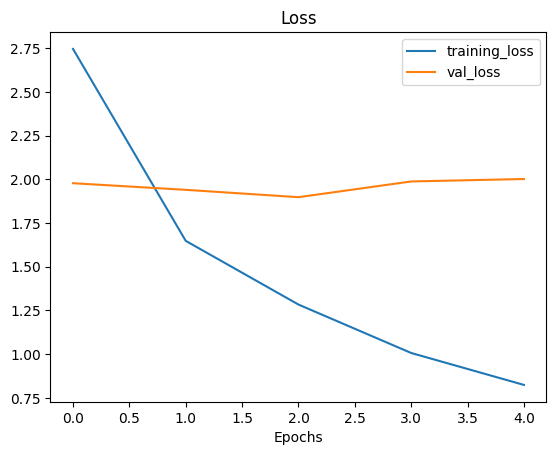

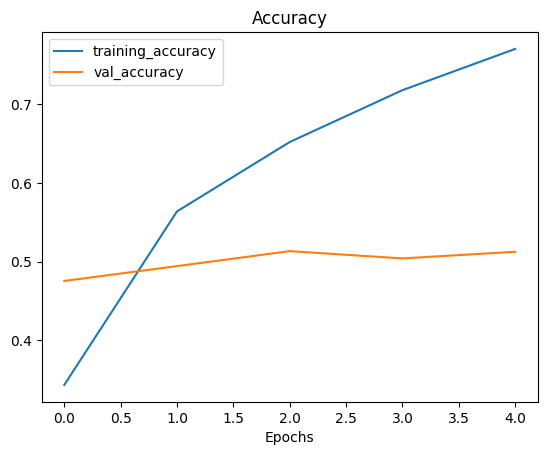

In [13]:
plot_loss_curves(history_all_classes_10_percent)

#Fine-tuning

In [14]:
#Unfreeze all layers in the base model
base_model.trainable=True

#Refreeze evry layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [16]:
#Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower learning rate than default
              metrics=["accuracy"]
              )

In [17]:
# Check what layers are trainable
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
#for layer_number, layer in enumerate(base_model.layers):
  #print(layer_number, layer.name, layer.trainable)

In [18]:
#Fine tune for 5 epochs more
fine_tune_epochs=10 #5+5 from previews
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 77s 296ms/step - loss: 0.4635 - accuracy: 0.8741 - val_loss: 1.7729 - val_accuracy: 0.5699
Epoch 6/10
237/237 [==============================] - 66s 277ms/step - loss: 0.3714 - accuracy: 0.9036 - val_loss: 1.7833 - val_accuracy: 0.5699
Epoch 7/10
237/237 [==============================] - 64s 269ms/step - loss: 0.3468 - accuracy: 0.9102 - val_loss: 1.8145 - val_accuracy: 0.5630
Epoch 8/10
237/237 [==============================] - 62s 263ms/step - loss: 0.3118 - accuracy: 0.9237 - val_loss: 1.8121 - val_accuracy: 0.5667
Epoch 9/10
237/237 [==============================] - 62s 261ms/step - loss: 0.2915 - accuracy: 0.9275 - val_loss: 1.8330 - val_accuracy: 0.5651
Epoch 10/10
237/237 [==============================] - 55s 230ms/step - loss: 0.2756 - accuracy: 0.9300 - val_loss: 1.8541 - val_accuracy: 0.5644


In [19]:
# Evaluate the fien tune model
results_fine_tune_model=model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 55s 70ms/step - loss: 1.6217 - accuracy: 0.6149


[1.621698021888733, 0.6149306893348694]

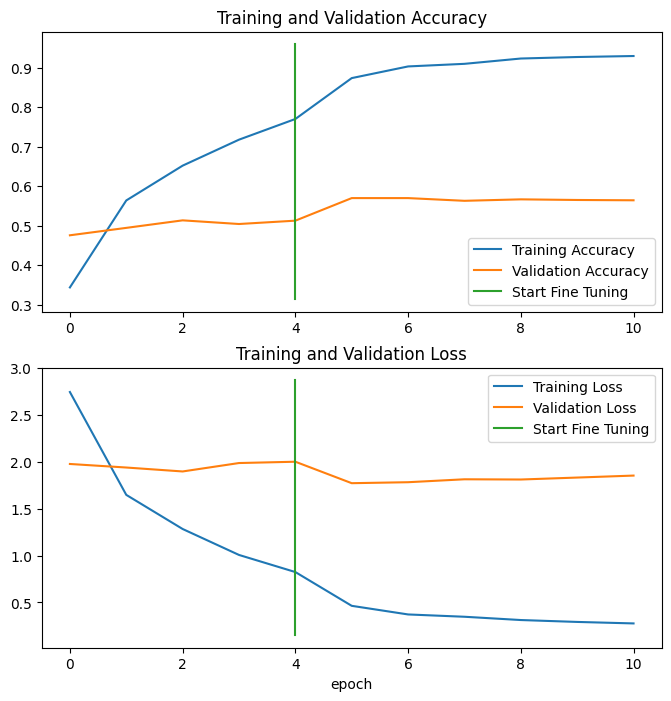

In [20]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
# # Save model to drive so it can be used later
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")